In [16]:
# import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["figure.dpi"] = 150
import seaborn as sns
import os
import joblib

# enable copy on write (default in pandas 3.0)
pd.options.mode.copy_on_write = True

In [17]:
def read_merged(weather, year):
    return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year)).drop(columns=['Unnamed: 0'])

In [18]:
meso = pd.concat([read_merged('meso', year) for year in range(2015, 2023)])

In [19]:
meso.replace({'TVS':{'Y': True, 'N': False}}, inplace=True)

In [33]:
read_merged('meso',2022)

,DATE,MONTH,LAT,LON,STR_RANK,LL_ROT_VEL,LL_DV,LL_BASE,DEPTH_KFT,DPTH_STMRL,MAX_RV_KFT,MAX_RV_KTS,TVS,MSI,COUNTY,STATE,POWER_OUTAGE
0,2022-01-01,1,38.000647,-76.098087,5,35,38,9,16,100,9,35,N,3237,Somerset County,Maryland,False
1,2022-01-01,1,37.504227,-74.733357,5,24,24,16,23,100,20,27,N,2382,Accomack County,Virginia,False
2,2022-01-01,1,37.997510,-75.268599,6,29,33,15,22,100,15,29,N,2763,Accomack County,Virginia,False
3,2022-01-01,1,35.108890,-101.844950,7L,15,23,4,12,58,11,53,N,4985,Potter County,Texas,False
4,2022-01-01,1,35.261530,-101.529170,5,24,43,6,16,100,21,68,N,4459,Carson County,Texas,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667082,2022-12-31,12,34.850490,-119.972930,5L,56,65,1,3,100,1,56,N,5749,Santa Barbara County,California,False
667083,2022-12-31,12,34.815300,-120.075310,5L,49,82,1,3,100,1,49,N,5176,Santa Barbara County,California,False
667084,2022-12-31,12,34.815300,-120.075310,5L,49,82,1,3,100,1,49,N,5176,Santa Barbara County,California,False
667085,2022-12-31,12,34.893480,-120.018830,5L,41,47,1,3,100,1,41,N,3530,Santa Barbara County,California,False


In [21]:
features = ['MONTH', 'LAT', 'LON', 'LL_ROT_VEL', 'LL_DV', 'LL_BASE', 'DEPTH_KFT', 'DPTH_STMRL',
            'MAX_RV_KFT', 'MAX_RV_KTS', 'TVS', 'MSI']
X,y = meso[features], meso['POWER_OUTAGE']

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)
X_tt, X_val, y_tt, y_val = train_test_split(X_train,y_train, test_size=0.2, stratify=y_train)

ValueError: Input contains NaN

In [9]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline

# XGBoost

In [20]:
from xgboost import XGBClassifier
xgb_model = Pipeline([('resampler',RandomUnderSampler()), ('clf',XGBClassifier(objective = 'binary:logistic'))])

In [21]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'clf__max_depth': range (5, 17,  2),
    'clf__n_estimators': range(100, 440, 40),
    'clf__learning_rate': [0.01, 0.1, 0.3]
}

grid_search = GridSearchCV(xgb_model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    verbose=True)
grid_search.fit(X_tt, y_tt)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('resampler', RandomUnderSampler()),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'clf__learning_rate': [0.01, 0.1, 0.3],
                         'clf__max_depth': range(5, 17, 2),
                         'clf__n_estimators': range(100, 440, 40)},
             scoring='f1', verbose=True)

In [22]:
best_model = grid_search.best_estimator_

## Saving model

In [25]:
joblib.dump(best_model,'../../models/xgb_meso.pkl')

['../../models/xgb_meso.pkl']

# Random forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf_model = Pipeline([('resampler',RandomUnderSampler()), ('clf',RandomForestClassifier())])

In [ ]:
parameters = {
    'clf__max_depth': range (10, 16),
    'clf__n_estimators': [200,300,400],
}

grid_search = GridSearchCV(rf_model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    verbose=True)
grid_search.fit(X_tt, y_tt)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [ ]:
rf = grid_search.best_estimator_

In [ ]:
joblib.dump(rf,'../../models/rf_meso.pkl')

# SVC

In [ ]:
from sklearn.svm import SVC
parameters = {'clf__C': [0.1, 1, 10, 100, 1000], 
              'clf__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'clf__kernel': ['poly', 'rbf', 'sigmoid']}
svc_model = Pipeline([('resampler', RandomUnderSampler()), ('scaler', StandardScaler()), ('clf', SVC())])
grid_search = GridSearchCV(svc_model, parameters, refit = True, verbose=15, n_jobs=6, cv = 3)
grid_search.fit(X_tt,y_tt)

In [ ]:
svc = grid_search.best_estimator_

In [ ]:
joblib.dump(svc,'../../models/svc_meso.pkl')

# Quadratic discriminant analysis

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
parameters = {'clf__reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]}
qda_model = Pipeline([('resampler', RandomUnderSampler()), ('scaler', StandardScaler()), ('clf', QuadraticDiscriminantAnalysis())])
grid_search = GridSearchCV(qda_model, parameters, refit = True, verbose=15, n_jobs=6, cv = 5)
grid_search.fit(X_tt,y_tt)

In [ ]:
qda = grid_search.best_estimator_

In [ ]:
joblib.dump(qda,'../../models/qda_meso.pkl')

# K nearest neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
parameters = {'clf__n_neighbors' : range(1,56)}
knn_model = Pipeline([('resampler', RandomUnderSampler()), ('scaler', StandardScaler()), ('clf', KNeighborsClassifier())])
grid_search = GridSearchCV(knn_model, parameters, refit=True, verbose=15, n_jobs=6, cv=5)

In [ ]:
knn = grid_search.best_estimator_

In [ ]:
joblib.dump(knn,'../../models/knn_meso.pkl')

# Examining performance 

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score, PrecisionRecallDisplay

In [6]:
xgb_meso = joblib.load('../../models/xgb_meso.pkl')

In [13]:
xgb_predictions = xgb_meso.predict(X_val)
print('xGBoost results')
print('precision: ', precision_score(y_val,xgb_predictions))
print('recall: ', recall_score(y_val,xgb_predictions))
print('f1: ', f1_score(y_val,xgb_predictions))
print('accuracy score: ', accuracy_score(y_val,xgb_predictions))
print('balanced accuracy score: ', balanced_accuracy_score(y_val,xgb_predictions))

xGBoost results
precision:  0.17528142724158116
recall:  0.9536850899407358
f1:  0.29613506009201274
accuracy score:  0.8043859313147881
balanced accuracy score:  0.8756692447898873


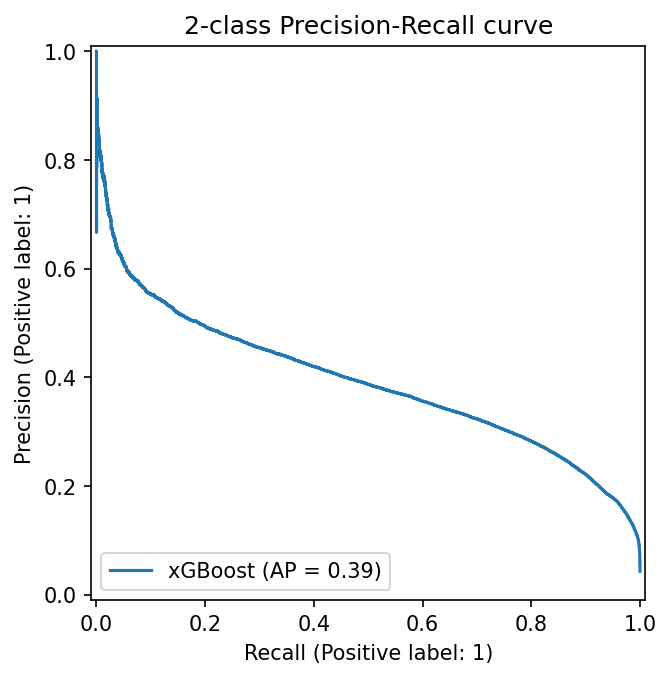

In [14]:
display = PrecisionRecallDisplay.from_estimator(
    xgb_meso, X_val, y_val, name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")